In [0]:
import pandas as pd
train=pd.read_csv('https://raw.githubusercontent.com/javalillo13689/hackspace/master/train.csv')

# Presentacion del dataset Housing Price California

In [21]:
train.shape

(1460, 81)

In [22]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Procesamiento de Datos

In [0]:
#importamos las librerias
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
import missingno as ms

Se necesita eliminar la variable **Id** debido a que esta variable no es relevante para predecir el precio de una casa.

In [0]:
train.drop("Id", axis = 1, inplace = True)

##OUTLIERS

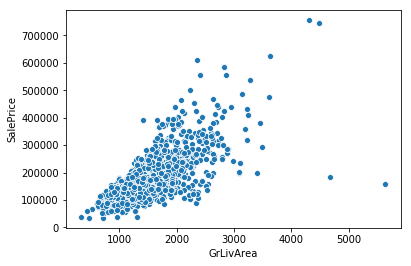

In [25]:
sns.scatterplot(x = train['GrLivArea'], y = train['SalePrice'])

Se puede apreciar en la esquina inferior derecha dos datos que indican un **AreaHabitable** muy grande, y sin embargo registran un bajo precio. Estos valores se consideran outliers. Por ello procederemos a eliminarlos.

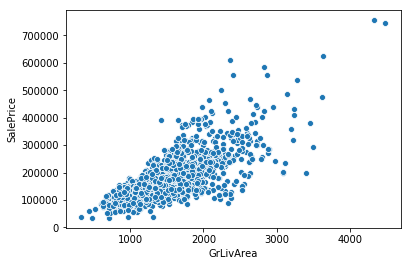

In [26]:
#Eliminamos los outliers acorde a las variables del gráfico
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Verificamos el gráfico nuevamente para confirmar que los outliers hayan sido eliminados
sns.scatterplot(x = train['GrLivArea'], y = train['SalePrice'])

Hay probabilidades de que otros valores atipicos existan en los datos de entrenamiento (si es que alli hubieran tambien outliers), sin embargo removerlos todos puede afectar negativamente nuestros modelos. Por ello vamos a permitir aquellos en los cuales los modelos son lo suficientemente robustos.

##Variable Objetivo

**Precio** es la variable que vamos a predecir. Asi que vamos a hacer un poco de analisis en esta variable primero.

Text(0.5, 1.0, 'Distribución del Precio')

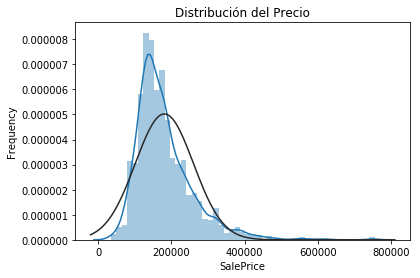

In [27]:
sns.distplot(train['SalePrice'] , fit=norm)
plt.ylabel('Frequency')
plt.title('Distribución del Precio')

Se puede apreciar que los datos de la variable objetivo están sesgados (en este caso, inclinado a la izquierda). Sin embargo, los modelos lineales que veremos en la presente clase optimizan su predición con datos distribuidos normalmente. Por ello vamos a transformar los datos de esta variable para aproximarlos a una distribución normal.

 **Log-transformación de la variable objetivo**

Text(0.5, 1.0, 'Distribución del Precio Real Ajustado')

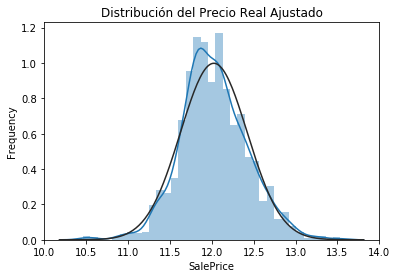

In [28]:
#Utilizamos la función log1p de la librería numpy que aplica la función log(1+x) a todos los elementos de la variable Precio
train["SalePrice"] = np.log1p(train["SalePrice"])

#Dibujamos la distribución actualizada de la variable Precio
sns.distplot(train['SalePrice'] , fit=norm);

plt.ylabel('Frequency')
plt.title('Distribución del Precio Real Ajustado')

# Ingeniería de Características ( I )

Vamos a revisar el archivo "DescripcionVariables.xlsx" el cual contiene un diccionario sobre el significado de las variables predictoras

In [0]:
y_train = train.SalePrice.values
train.drop(['SalePrice'], axis=1, inplace=True)

###Hallando nulos

Procedemos a utilizar la función **ms.matrix** para visualizar de forma rápida los nulos del dataset.

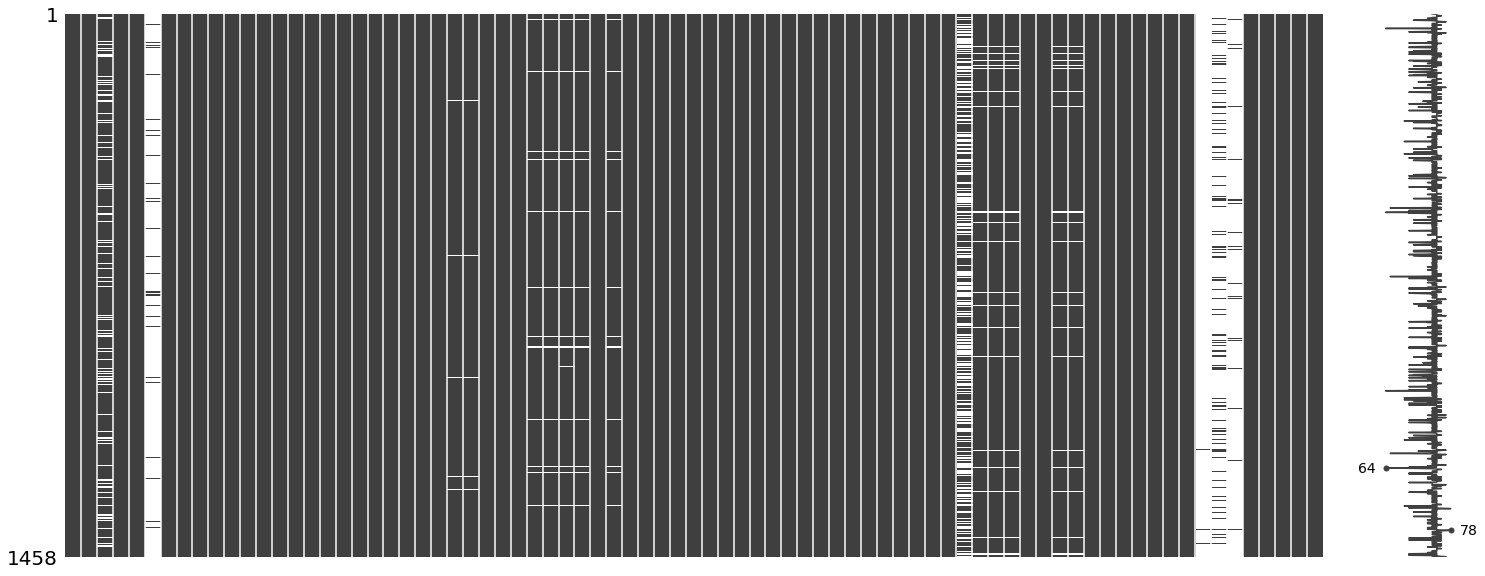

In [30]:
ms.matrix(train)

**Correlación de los Datos**


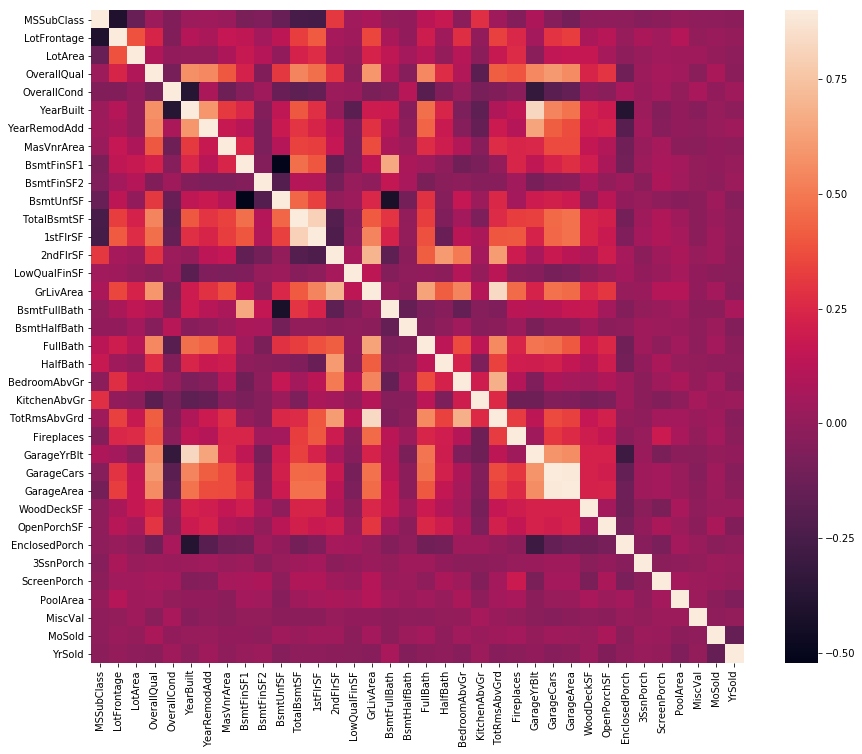

In [31]:
#Mapa de correlación para ver cómo las variables predictoras están correlacionadas con Precio
corrmat = train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corrmat, vmax=0.9, square=True)

###Completando valores nulos

Vamos a completar secuencialmente los nulos para todas las características que cuenten con valores perdidos.

- **Piscina** : None hace referencia a que la casa no cuente con piscina.

In [0]:
train["PoolQC"] = train["PoolQC"].fillna("None")

- **Miscelaneo** : None hace referencia a que la casa no cuenta con características especiales que califiquen como Misceláneo


In [0]:
train["MiscFeature"] = train["MiscFeature"].fillna("None")

- **Callejon** : None hace referencia a que la casa no cuenta con acceso a callejón.

In [0]:
train["Alley"] = train["Alley"].fillna("None")

- **Cerca** : None hace referencia a que la casa no cuenta con cerca

In [0]:
train["Fence"] = train["Fence"].fillna("None")

- **ChimeneaCalidad** : None hace referencia a que la casa no cuenta con chimenea

In [0]:
train["FireplaceQu"] = train["FireplaceQu"].fillna("None")

- **Fachada** : Los valores perdidos de la **Fachada** los completaremos con la mediana obtenida al agrupar las casas por vecindario

In [0]:
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

- **GarajeTipo,GarajeExteriores,GarajeCalidad,GarajeCondición** : Los valores perdidos serán reemplazados por None para registrar que no cuentan con Garaje ni ninguna de sus características

In [0]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    train[col] = train[col].fillna('None')

- **GarajeAñosConstruido, GarajeArea y GarajeCarros** : Los valores perdidos los reemplazamos por cero (0) debido a que la casa no registró garaje.


In [0]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    train[col] = train[col].fillna(0)

- **SotanoAreaFinalizadaTipo1, SotanoAreaFinalizadaTipo2,SotanoAreaNoFinalizada, TotalAreaSotano, SotanoBañosCompletos y SotanosBañosSemicimpletos** :  Los valores perdidos los reemplazamos por cero (0) debido a que la casa no registró sótanos

In [0]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    train[col] = train[col].fillna(0)

- **SotanoCalidad, SotanoCondicion, SotanoExteriores, SotanoFinalizadoTipo1 and SotanoFinalizadoTipo2** : Los valores perdidos serán reemplazados por None para registrar que no cuentan con Sótano ni ninguna de sus características


In [0]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train[col] = train[col].fillna('None')

- **ChapaAlbañileríaArea y ChapaAlbañileríaTipo** : Los valores perdidos serán reemplazados por cero (0) y None respectivamente para registrar que la casa no cuenta con Chapa de Albañilería


In [0]:
train["MasVnrType"] = train["MasVnrType"].fillna("None")
train["MasVnrArea"] = train["MasVnrArea"].fillna(0)

- **ClaseZona** :  Los valores perdidos serán reemplazados por la moda, es decir la característica más frecuente de la ClaseZona ('RL')

In [0]:
train['MSZoning'] = train['MSZoning'].fillna(train['MSZoning'].mode()[0])

- **Utilities** : Esta variable está completamente llena con un **único valor para todos los registros** por ello no vamos a considerarla para la predicción.


In [0]:
train = train.drop(['Utilities'], axis=1)

- **TipoDeclaracionImpuestos** : Asumimos para los datos perdidos la cateogría **Typ** (típica) para la forma de declaración de impuestos

In [0]:
train["Functional"] = train["Functional"].fillna("Typ")

- **SistemaElectrico** : Solo presenta 1 dato perdido así que vamos a reemplazarlo por la moda


In [0]:
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])

- **CocinaCalidad**:  Solo presenta 1 dato perdido así que vamos a reemplazarlo por la moda


In [0]:
train['KitchenQual'] = train['KitchenQual'].fillna(train['KitchenQual'].mode()[0])

- **Exteriores1erPiso and Exteriores2doPiso** : Ambas variables solo cuentan con 1 dato perdido así que vamos a reemplazarlo por la moda

In [0]:
train['Exterior1st'] = train['Exterior1st'].fillna(train['Exterior1st'].mode()[0])
train['Exterior2nd'] = train['Exterior2nd'].fillna(train['Exterior2nd'].mode()[0])

- **TipoVenta** : Los valores perdidos serán reemplazados por la moda, es decir la característica más frecuente del tipo de venta

In [0]:
train['SaleType'] = train['SaleType'].fillna(train['SaleType'].mode()[0])

- **SubClase** : None hace referencia a que la casa no registró el tipo de construcción


In [0]:
train['MSSubClass'] = train['MSSubClass'].fillna("None")

Procedemos a verificar si queda algún dato nulo en el dataset:

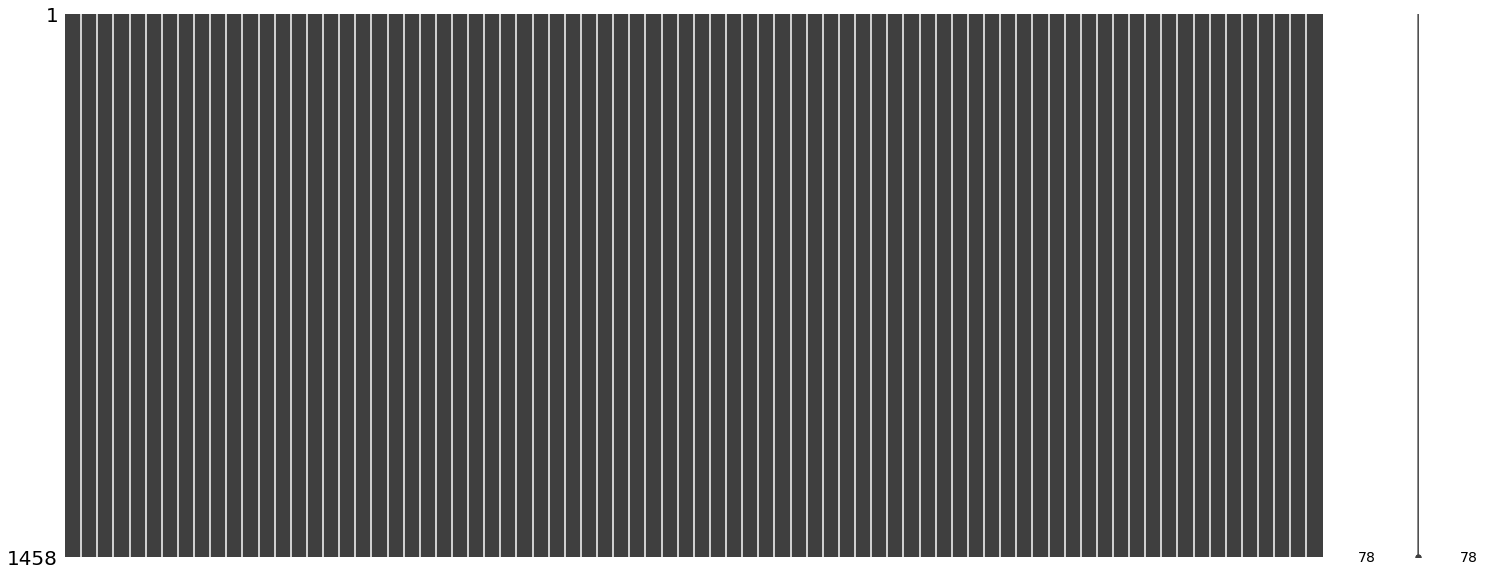

In [53]:
ms.matrix(train)

# Ingeniería de Características ( II )

**Transformando algunas variables númericas que realmente son categóricas**

In [0]:
#Cambiar las variables Año y Mes de venta de la casa a tipo letra (str)
train['YrSold'] = train['YrSold'].astype(str)
train['MoSold'] = train['MoSold'].astype(str)

**Añadimos una variable importante**

Debido a que el área total es importante para predecir el precio de la casa, sumamos las tres variables **TotalSótano, 1erPiso, 2doPiso**

In [0]:
#Añadiendo tamaño total del area
train['TotalArea'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']

**Detectamos el sesgo de las variables predictoras** - Solo aquellas con data numérica

In [56]:
#Filtramos aquellas variables que tengan datos diferentes al tipo object, es decir numéricas
numeric_feats = train.dtypes[train.dtypes != "object"].index

#Aplicamos la función skew a las variables filtradas y mostramos el resultado ordenando de forma ascendente
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSesgo en características numéricas: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Sesgo en características numéricas: 



,Skew
MiscVal,24.434913
PoolArea,15.932532
LotArea,12.560986
3SsnPorch,10.286510
LowQualFinSF,8.995688
KitchenAbvGr,4.480268
BsmtFinSF2,4.247550
ScreenPorch,4.114690
BsmtHalfBath,4.095895
EnclosedPorch,3.083987


**Transformación Box Cox**

Usamos la transformación BoxCox de la librería scipy

In [57]:
skewness = skewness[abs(skewness) > 0.75]
print("Hay {} características numéricas que se han transformado vía BoxCox".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    train[feat] = boxcox1p(train[feat], lam)

Hay 35 características numéricas que se han transformado vía BoxCox


**Generamos nuevas variables dummy**

In [58]:
train=pd.get_dummies(train, prefix_sep='_', drop_first=True)
print(train.shape)

(1458, 271)


In [59]:
train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,TotalArea,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,...,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_None,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,5.684507,5.831328,19.212182,2.440268,2.055642,14.187527,14.187527,8.059126,11.170327,0.0,7.483296,11.692623,11.692623,11.686189,0.0,13.698888,0.730463,0.000000,1.194318,0.730463,1.540963,0.730463,2.602594,0.000000,14.187527,1.194318,10.506271,0.000000,5.714669,0.000000,0.0,0.0,0.0,0.0,14.976591,0,0,1,0,1,...,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,3.858807,6.221214,19.712205,2.259674,2.602594,14.145138,14.145138,0.000000,12.062832,0.0,8.897844,12.792276,12.792276,0.000000,0.0,12.792276,0.000000,0.730463,1.194318,0.000000,1.540963,0.730463,2.259674,0.730463,14.145138,1.194318,10.062098,9.010206,0.000000,0.000000,0.0,0.0,0.0,0.0,14.923100,0,0,1,0,1,...,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,5.684507,5.914940,20.347241,2.440268,2.055642,14.184404,14.185966,7.646538,10.200343,0.0,9.917060,11.892039,11.892039,11.724598,0.0,13.832085,0.730463,0.000000,1.194318,0.730463,1.540963,0.730463,2.259674,0.730463,14.184404,1.194318,10.775536,0.000000,5.053371,0.000000,0.0,0.0,0.0,0.0,15.149678,0,0,1,0,1,...,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,5.968981,5.684507,19.691553,2.440268,2.055642,14.047529,14.135652,0.000000,8.274266,0.0,10.468500,11.354094,12.013683,11.354094,0.0,13.711364,0.730463,0.000000,0.730463,0.000000,1.540963,0.730463,2.440268,0.730463,14.179714,1.540963,10.918253,0.000000,4.745132,8.797736,0.0,0.0,0.0,0.0,14.857121,0,0,1,0,1,...,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,5.684507,6.314735,21.325160,2.602594,2.055642,14.182841,14.182841,9.391827,10.971129,0.0,10.221051,12.510588,12.510588,12.271365,0.0,14.480029,0.730463,0.000000,1.194318,0.730463,1.820334,0.730463,2.750250,0.730463,14.182841,1.540963,11.627708,8.013884,6.314735,0.000000,0.0,0.0,0.0,0.0,15.852312,0,0,1,0,1,...,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


# Modelos

**Importamos librerías**

In [0]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error

##Modelos Base

-  **Regresión Lasso**  : 

Este modelo es muy sensible a outliers, por ello necesitamos hacer más robusto el modelo a través del parámetro **Robustscaler** dentro de un pipeline

In [0]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

- **Regresión ElasticNet** :

Nuevamente ingresamos el parámetro **Robustscaler** dentro del pipeline para hacer más robusto el modelo

In [0]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=1))

- **Regresión Kernel Ridge** :

In [0]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

# Evaluación de los Modelos Base

In [66]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1137 (0.0061)



In [67]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1137 (0.0062)



In [68]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1156 (0.0056)

